In [3]:
import numpy as np, matplotlib.pyplot as plt
from astropy.io import ascii as asc
import sys
sys.path.append('../')

%matplotlib inline

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0
CUTOFF_MASS = 6.0

### plotting EBVs against each other

In [4]:
xarr = np.arange(0,2,0.1)

In [5]:
fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.GALEX.fout',
                 guess=False,Reader=asc.NoHeader)

corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',
    guess=False, Reader=asc.FixedWidthTwoLine)

# defining a flux sigma and mass cutoff
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & 
    (corr_tbl['stlr_mass'] >= CUTOFF_MASS))[0]
corr_tbl = corr_tbl[good_sig_iis]

EBV_HA = corr_tbl['EBV'].data
corrID = corr_tbl['ID'].data
corrfilts = corr_tbl['filt'].data
corrzspec0 = corr_tbl['zspec0'].data
dust_corr_factor = corr_tbl['dust_corr_factor'].data
filt_corr_factor = corr_tbl['filt_corr_factor'].data
nii_ha_corr_factor = corr_tbl['nii_ha_corr_factor'].data
corr_factors = filt_corr_factor + nii_ha_corr_factor + dust_corr_factor

good_NBIA_sig_iis = corr_tbl['ID'].data - 1

In [6]:
# iis = np.digitize(xvals, bins=plot_bins)

In [7]:
min(corr_tbl['obs_lumin'].data)

37.9825790872

In [8]:
# getting/storing useful data
no_spectra  = np.where((corrzspec0 <= 0) | (corrzspec0 > 9))[0]
yes_spectra = np.where((corrzspec0 >= 0) & (corrzspec0 < 9))[0]

In [9]:
# using the calzetti dust attenuation law
# EBV = A_V/k'
A_V = fout['col6'].data[good_NBIA_sig_iis]
V_lambda  = 0.55 # units of micron
K_V       = (2.659*(-2.156 + 1.509/V_lambda - 0.198/V_lambda**2
                    + 0.011/V_lambda**3)+ 4.05)
EBV_SED = A_V/K_V

In [10]:
K_V # = 4.05

4.0478903801652875

In [11]:
# all in log val
# L1500_corr = L1500_obs + 0.4*k(1500)*E(B-V)_SED
# SFR(1500) = L(1500) + corr(Z)

In [12]:
A_UV = K_V*0.44*EBV_HA

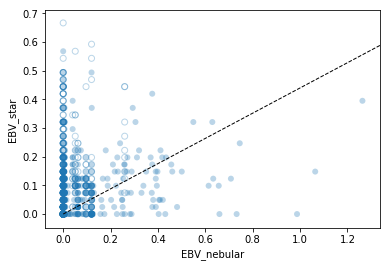

In [13]:
for idxs, fc, ec in zip([yes_spectra, no_spectra], ['#1f77b4', 'none'], ['none', '#1f77b4']):
    plt.scatter(EBV_HA[idxs], EBV_SED[idxs], marker='o', facecolors=fc, edgecolors=ec, alpha=0.3)

plt.xlabel('EBV_nebular') # from HA
plt.ylabel('EBV_star') # from UV / SED
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot(xarr,0.44*xarr, 'k--')
plt.show()

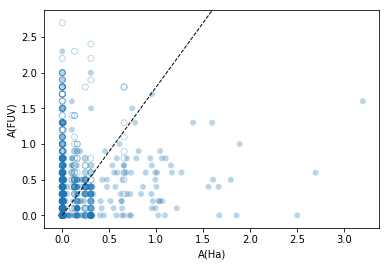

In [14]:
for idxs, fc, ec in zip([yes_spectra, no_spectra], ['#1f77b4', 'none'], ['none', '#1f77b4']):
    plt.scatter(corr_tbl['A(Ha)'].data[idxs], A_V[idxs], 
                marker='o', facecolors=fc, edgecolors=ec, alpha=0.3)

plt.xlabel('A(Ha)')
plt.ylabel('A(FUV)')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot(xarr*3, 1.8*xarr*3, 'k--')

### deriving UV SFR from the 1500$\unicode{x212B}$ measurements

In [15]:
npz_files = np.load(FULL_PATH+'Plots/sfr_metallicity_plot_fit.npz')

nuLnu_fit_ch = npz_files['nuLnu_fit_ch']
Lnu_fit_ch = npz_files['Lnu_fit_ch']
Lnu_fit_kr = npz_files['Lnu_fit_kr']
nuLnu_LHa_fit_ch = npz_files['nuLnu_LHa_fit_ch']
nuLnu_LHa_fit_kr = npz_files['nuLnu_LHa_fit_kr']
LHa_fit_ch = npz_files['LHa_fit_ch']
nuLnu_fit_kr = npz_files['nuLnu_fit_kr']
LHa_fit_kr = npz_files['LHa_fit_kr']

In [16]:
# y = P0 + P1 log(Z/Z_sol) + P2 log(Z/Z_sol)^2
P2, P1, P0 = -1*Lnu_fit_ch

In [17]:
def log_SFR_from_L(y, P2, P1, P0):
    '''z is metallicity'''
    return P0 + P1*y + P2*y**2

In [18]:
from mainseq_corrections import niiha_oh_determine
NII6583_Ha = corr_tbl['NII_Ha_ratio'].data * 2.96/(1+2.96)
logOH = niiha_oh_determine(np.log10(NII6583_Ha), 'PP04_N2') - 12   # since this code estimates log(O/H)+12
y = logOH + 3.31

log_SFR_LUV = log_SFR_from_L(y, P2, P1, P0)

In [19]:
HA = 6562.80
centr_filts = {'NB7':((7045.0/HA - 1) + (7126.0/HA - 1))/2.0, 
               'NB816':8152.0/HA - 1, 'NB921':9193.0/HA - 1, 'NB973':9749.0/HA - 1}

In [20]:
import plot_mainseq_UV_Ha_comparison
reload(plot_mainseq_UV_Ha_comparison)
from plot_mainseq_UV_Ha_comparison import get_flux_from_FAST

In [21]:
import astropy.units as u
from plot_mainseq_UV_Ha_comparison import get_flux_from_FAST
from astropy import constants
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 70 * u.km / u.s / u.Mpc, Om0=0.3)

def get_LUV(filt_index_haii, ff):
    ID = corrID[filt_index_haii]
    zspec = corrzspec0[filt_index_haii]

    goodz = np.where((zspec >= 0) & (zspec < 9))[0]
    badz  = np.where((zspec <= 0) | (zspec > 9))[0]

    tempz = np.zeros(len(filt_index_haii))
    tempz[goodz] = zspec[goodz]
    tempz[badz] = centr_filts[ff]

    lambda_arr = (1+tempz)*1500

    f_lambda = get_flux_from_FAST(ID, lambda_arr)
    f_nu = f_lambda*(1E-19*(lambda_arr**2*1E-10)/(constants.c.value))
    log_L_nu = np.log10(f_nu*4*np.pi) + \
        2*np.log10(cosmo.luminosity_distance(tempz).to(u.cm).value)

    return log_L_nu

In [22]:
LUV = np.zeros(len(corr_tbl))
for ff in ['NB7','NB816','NB921','NB973']:
    filt_index_haii = np.array([x for x in range(len(corr_tbl)) if ff in
        corrfilts[x]])

    lnu = get_LUV(filt_index_haii, ff)
    LUV[filt_index_haii] = lnu

In [23]:
log_SFR_UV = log_SFR_LUV + LUV

In [24]:
log_SFR_Ha = corr_tbl['met_dep_sfr'].data

In [25]:
min(log_SFR_Ha), max(log_SFR_Ha)

(-3.53206876806, 0.379736597978)

In [26]:
yvals = log_SFR_Ha - log_SFR_UV

In [27]:
zspec0 = corr_tbl['zspec0'].data
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]
assert len(no_spectra)+len(yes_spectra) == len(zspec0)

In [28]:
min_yesz_per_bin = 10

In [29]:
def get_tempz(zspec0, filt_arr):
    '''
    '''
    HA = 6562.80
    centr_filts = {'NB7':((7045.0/HA - 1) + (7126.0/HA - 1))/2.0, 
        'NB704':((7045.0/HA - 1) + (7126.0/HA - 1))/2.0, 
        'NB711':((7045.0/HA - 1) + (7126.0/HA - 1))/2.0, 
        'NB816':8152.0/HA - 1, 'NB921':9193.0/HA - 1, 'NB973':9749.0/HA - 1}

    tempz = np.zeros(len(zspec0))
    for ii, zspec in enumerate(zspec0):
        if (zspec > 0 and zspec < 9):
            tempz[ii] = zspec
        elif (zspec <= 0 or zspec > 9):
            tempz[ii] = centr_filts[filt_arr[ii]]
        else:
            raise ValueError('something went wrong with zspecs?')

    return tempz

In [30]:
tempz = get_tempz(zspec0, corr_tbl['filt'].data)

In [31]:
fluxarr = np.array([])
for ii, ID in enumerate(corr_tbl['ID'].data):
    lambda_arr = (1+tempz[ii])*4400.00
    # flux in (x 10^-19 ergs s^-1 cm^-2 Angstrom^-1)
    flux_lambda = get_flux_from_FAST(ID, lambda_arr, byarr=False)
    # flux in (x 10^-19 ergs s^-1 cm^-2 Hz^-1)
    flux_nu = flux_lambda*(1E-19*(lambda_arr**2*1E-10)/(constants.c.value))
    fluxarr = np.append(fluxarr, flux_nu)

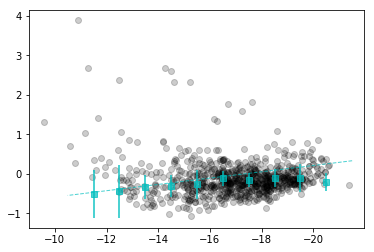

In [32]:
D_L = cosmo.luminosity_distance(tempz).to(u.pc).value
M_B = (-2.5*np.log10(fluxarr)-48.6) - 5*np.log10(D_L/((10*u.pc).value)) + 2.5*np.log10(1+tempz) 
plt.plot(M_B, yvals, 'ko', alpha=0.2)
plt.xlim(plt.gca().get_xlim()[::-1])

jlee_xarr = np.array([-20.5,-19.5,-18.5,-17.5,-16.5,-15.5,-14.5,
    -13.5,-12.5,-11.5])
jlee_logSFR_ratio = np.array([-0.21,-0.10,-0.10,-0.16,-0.12,-0.27,
    -0.30,-0.34,-0.45,-0.51])
jlee_logSFR_ratio_errs = np.array([0.23,0.36,0.23,0.17,0.18,0.36,
    0.28,0.30,0.67,0.61])

plt.plot(jlee_xarr, jlee_logSFR_ratio, 'cs', alpha=0.7, zorder=11)
plt.errorbar(jlee_xarr, jlee_logSFR_ratio, fmt='none', ecolor='c', lw=2,
    yerr=jlee_logSFR_ratio_errs, alpha=0.7, zorder=10)
xtmparr0 = np.linspace(min(jlee_xarr)-1, max(jlee_xarr)+1, 10)
plt.plot(xtmparr0, -0.08*xtmparr0-1.39, 'c--', alpha=0.7)

plt.show()

In [33]:
min(5*np.log10(D_L/((10*u.pc).value)) + 2.5*np.log10(1+tempz)), max(5*np.log10(D_L/((10*u.pc).value)) + 2.5*np.log10(1+tempz))

(37.49114101818209, 42.69190559557982)

In [34]:
max(5*np.log10(D_L/((10*u.pc).value)) + 2.5*np.log10(1+tempz))-min(5*np.log10(D_L/((10*u.pc).value)) + 2.5*np.log10(1+tempz))

5.200764577397727

### without dust correction

In [35]:
# jlee_logSFRHa = np.array([0.25,-0.25,-0.75,-1.25,-1.75,-2.25,-2.75,-3.5,-4.5])
jlee_logSFRUV = np.array([-2.21,-1.45,-0.7,-0.4,-0.26,-1.94,-2.04,-2.05,-2.52,-2.3])
# jlee_logSFR_ratio = np.array([0.2,0.17,0.07,-0.02,-.1,-.23,-.46,-.49,-1.29])

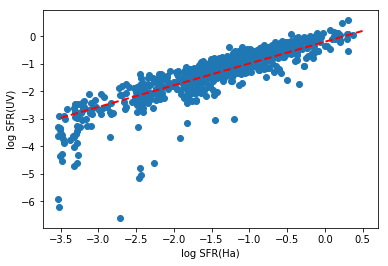

In [36]:
xtmparr = np.arange(-3.5,1.0,0.5)
plt.plot(log_SFR_Ha, log_SFR_UV, 'o')
plt.xlabel('log SFR(Ha)')
plt.ylabel('log SFR(UV)')
# plt.plot(jlee_logSFRHa, jlee_logSFRUV, 'rs')
plt.plot(xtmparr, 0.79*xtmparr-0.2, 'r--', lw=2)

NameError: name 'jlee_logSFRHa' is not defined

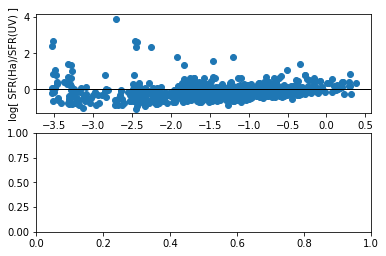

In [37]:
f, ax = plt.subplots(2,1)

ax[0].plot(log_SFR_Ha, log_SFR_Ha - log_SFR_UV, 'o')
ax[0].set_xlabel('log SFR(Ha)')
ax[0].set_ylabel('log[ SFR(Ha)/SFR(UV) ]')
ax[0].axhline(0, color='k')
ax[0].plot(jlee_logSFRHa, jlee_logSFR_ratio, 'rs')
ax[0].plot(xtmparr, 0.26*xtmparr+0.3, 'r--', lw=2)

ax[1].plot(corr_tbl['stlr_mass'].data, log_SFR_Ha - log_SFR_UV, 'o')
ax[1].set_xlabel('mass')
ax[1].set_ylabel('log[ SFR(Ha)/SFR(UV) ]')
ax[1].axhline(0, color='k')

f.set_size_inches(6,8)

### with dust correction??

In [38]:
log_SFR_Ha_dustcorr = log_SFR_Ha + corr_factors

In [39]:
log_SFR_UV_dustcorr = log_SFR_UV + 0.4*A_UV

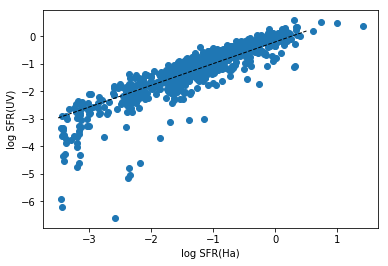

In [40]:
xtmparr = np.arange(-3.5,1.0,0.5)
# plt.plot(log_SFR_Ha + corr_factors, log_SFR_UV + corr_factors, 'o')
plt.plot(log_SFR_Ha_dustcorr, log_SFR_UV_dustcorr, 'o')
plt.xlabel('log SFR(Ha)')
plt.ylabel('log SFR(UV)')
plt.plot(xtmparr, 0.79*xtmparr-0.2, 'k--')

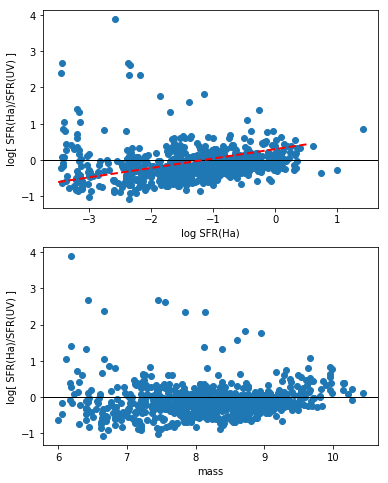

In [89]:
f, ax = plt.subplots(2,1)

ax[0].plot(log_SFR_Ha + corr_factors, log_SFR_Ha - log_SFR_UV, 'o')
ax[0].set_xlabel('log SFR(Ha)')
ax[0].set_ylabel('log[ SFR(Ha)/SFR(UV) ]')
ax[0].axhline(0, color='k')
ax[0].plot(xtmparr, 0.26*xtmparr+0.3, 'r--', lw=2)

ax[1].plot(corr_tbl['stlr_mass'].data, log_SFR_Ha - log_SFR_UV, 'o')
ax[1].set_xlabel('mass')
ax[1].set_ylabel('log[ SFR(Ha)/SFR(UV) ]')
ax[1].axhline(0, color='k')

f.set_size_inches(6,8)